<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **BERT analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), October 2025.

This notebook mirrors the [Word2Vec analysis](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_Word2Vec.ipynb) and [TF-IDF analysis](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_TFIDF.ipynb) structure for this study.

Here, we run the cosine similarity analyses and semantic similarity analyses using Bidirectional Encoder Representations from Transformers (BERT) embeddings.

For both of these analyses, two levels of investigation are conducted:
1. a broad cateorisation, grouping METs by the genre of the clip (N=4) and context (N=4) pairing (*= 16 documents*)
2. grouping METs by specific clip (N=16) and context (N=4) pairing (*= 64 documents*)


Overviews are described at the start of each analysis section, and Summaries at the end listing the file outputs.



## BERT analysis briefing

This code will be answering questions such as "Do people describe Jazz differently in BAR vs CONCERT contexts?" and "Is genre or context more important for similarity?"

* Document-level analysis
  * Creates one embedding per document (each genre-context or clip-context combination)
  * Builds a full similarity matrix between all documents
  * Extracts specific conditions from that matrix
* BERT embeddings
  * Uses mean pooling across all token embeddings for better document representation
  * Handles text truncation with 512 token limit
  * Processes each document individually for clean embeddings

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

rm: cannot remove 'context-framed-listening': No such file or directory
Cloning into 'context-framed-listening'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 237 (delta 33), reused 52 (delta 16), pack-reused 153 (from 1)
Receiving objects: 100% (237/237), 11.91 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (126/126), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

Initialise pretrained BERT model and tokeniser (_only need to do this once for this notebook_):

In [3]:
print("\nLoading BERT model and tokeniser...")
BERTtokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
BERTmodel = BertModel.from_pretrained('bert-base-uncased')
print("BERT model loaded successfully!\n")

# Function to get BERT embeddings for text
def get_bert_embedding(text):
    """Get BERT embedding for a single text document."""
    # Tokenise and encode the text
    inputs = BERTtokeniser(text, return_tensors='pt', padding=True,
                           truncation=True, max_length=512)

    # Get BERT outputs
    with torch.no_grad():
        outputs = BERTmodel(**inputs)

    # Use mean pooling of last hidden states as document embedding
    # Shape: (1, hidden_size) -> we take mean across all tokens
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding


Loading BERT model and tokeniser...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT model loaded successfully!



Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [4]:
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

---
## Cosine Similarity Analyses

**Version 1 (Genre-Context):**

* Groups by genre and context (broader categorisation)
* Produces 16 document combinations (4 genres × 4 contexts)


**Version 2 (Clip-Context):**

* Groups by specific clip and context pairing
* Produces 64 document combinations (16 clips × 4 contexts)

**OUTPUTS:**

* Cosine similarity value matrices
* Heatmap of cosine similarity values


====================================
### Version 1: Genre-Context Cosine Matrix
====================================

Combine the preprocessed MET descriptions from `dataMETpre` into "METdocs".


In [5]:
# Initialise DataFrame for Version 1
METdocs_v1 = pd.DataFrame(index=range(0,1), columns=dataMETpre.columns)
rowIndex = 0

# Iterate through each unique context word and genre
for idContext in np.unique(dataMETpre['context_word']):
    for idGenre in np.unique(dataMETpre['clip_genre']):
        # Create masks to filter data
        contextMask = dataMETpre['context_word'] == idContext
        genreMask = dataMETpre['clip_genre'] == idGenre

        # Combined mask
        mask = [all(tup) for tup in zip(contextMask, genreMask)]
        filt_ContextGenreData = dataMETpre[mask]

        # Concatenate all text descriptions
        descrSeries = filt_ContextGenreData['preprocessed_METdescr']

        # Join descriptions with marker
        joinedstring = ""
        for ival in range(0, len(descrSeries.values)):
            joinedstring = joinedstring + str(descrSeries.values[ival]) + " endofasubhere "

        # Assign values to dataframe
        METdocs_v1.loc[rowIndex, 'preprocessed_METdescr'] = joinedstring
        METdocs_v1.loc[rowIndex, 'idGenreContext'] = idContext[0:3] + "_" + idGenre[0:3]

        # Assign context code
        if idContext[0:3] == 'bar':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'BAR'
        elif idContext[0:3] == 'con':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'CON'
        elif idContext[0:3] == 'mov':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'MOV'
        elif idContext[0:3] == 'vid':
            METdocs_v1.loc[rowIndex, 'context_code'] = 'VID'

        # Assign genre code
        if idGenre[0:3] == '80s':
            METdocs_v1.loc[rowIndex, 'genre_code'] = '80s'
        elif idGenre[0:3] == 'Jaz':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Jaz'
        elif idGenre[0:3] == 'Met':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Met'
        elif idGenre[0:3] == 'Ele':
            METdocs_v1.loc[rowIndex, 'genre_code'] = 'Ele'

        rowIndex = rowIndex + 1

# Filter and save Version 1
METdocs_v1 = METdocs_v1.filter(['context_code', 'genre_code', 'preprocessed_METdescr', 'idGenreContext'], axis=1)
METdocs_v1.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_v1_GenreContext.csv', encoding='utf-8')

print(f"Version 1: Created {len(METdocs_v1)} documents (Genre-Context combinations)")
display(METdocs_v1.head(5))


Version 1: Created 16 documents (Genre-Context combinations)


,context_code,genre_code,preprocessed_METdescr,idGenreContext
0,BAR,80s,kind sad melancholy happy upbeat emotionally c...,bar_80s
1,BAR,Ele,feel busy drive something important something ...,bar_Ele
2,BAR,Jaz,dynamic could sway someone care could sit drin...,bar_Jaz
3,BAR,Met,upbeat would never hear maybe end credit somet...,bar_Met
4,CON,80s,bland lift something something would specifica...,con_80s


Compute cosine similarity for version 1:

In [6]:
# Load the METdocs data for Version 1
wordsin_v1 = METdocs_v1.copy()

# Compute BERT embeddings for each document
print("Computing BERT embeddings for Version 1 documents...")
bert_embeddings_v1 = []

for idx, row in wordsin_v1.iterrows():
    text = str(row['preprocessed_METdescr'])
    embedding = get_bert_embedding(text)
    bert_embeddings_v1.append(embedding)

    if (idx + 1) % 5 == 0:
        print(f"  Processed {idx + 1}/{len(wordsin_v1)} documents...")

bert_embeddings_v1 = np.array(bert_embeddings_v1)
print(f"Version 1: BERT embeddings shape: {bert_embeddings_v1.shape}")

# Calculate cosine similarity matrix
print("Computing cosine similarity matrix for Version 1...")
cosineMatrix_BERT_v1 = cosine_similarity(bert_embeddings_v1, bert_embeddings_v1)

# Create labeled DataFrame
cosineMatrix_BERT_v1_df = pd.DataFrame(
    cosineMatrix_BERT_v1,
    index=wordsin_v1['idGenreContext'],
    columns=wordsin_v1['idGenreContext']
)

# Save cosine similarity matrix
cosineMatrix_BERT_v1_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/cosineMatrix_BERT_v1_GenreContext.csv', encoding='utf-8')

print("\nVersion 1 BERT Cosine Similarity Matrix:")
display(cosineMatrix_BERT_v1_df)

Computing BERT embeddings for Version 1 documents...
  Processed 5/16 documents...
  Processed 10/16 documents...
  Processed 15/16 documents...
Version 1: BERT embeddings shape: (16, 768)
Computing cosine similarity matrix for Version 1...

Version 1 BERT Cosine Similarity Matrix:


idGenreContext,bar_80s,bar_Ele,bar_Jaz,bar_Met,con_80s,con_Ele,con_Jaz,con_Met,mov_80s,mov_Ele,mov_Jaz,mov_Met,vid_80s,vid_Ele,vid_Jaz,vid_Met
idGenreContext,,,,,,,,,,,,,,,,
bar_80s,1.000000,0.957971,0.984105,0.967094,0.970802,0.974773,0.972728,0.960377,0.971721,0.974699,0.960480,0.955285,0.968413,0.951149,0.982833,0.941993
bar_Ele,0.957971,1.000000,0.959297,0.973590,0.970629,0.971285,0.977302,0.971152,0.963992,0.973349,0.962638,0.974844,0.979002,0.980603,0.958842,0.972254
bar_Jaz,0.984105,0.959297,1.000000,0.967290,0.973190,0.972943,0.976141,0.962859,0.971536,0.972210,0.962339,0.956091,0.964843,0.949492,0.983857,0.947763
bar_Met,0.967094,0.973590,0.967290,1.000000,0.971579,0.969171,0.979936,0.983134,0.962730,0.970614,0.964102,0.979040,0.974222,0.974987,0.965580,0.973085
con_80s,0.970802,0.970629,0.973190,0.971579,1.000000,0.973811,0.982867,0.968739,0.974241,0.976615,0.974020,0.964275,0.979823,0.962054,0.969439,0.960553
con_Ele,0.974773,0.971285,0.972943,0.969171,0.973811,1.000000,0.977890,0.965303,0.977990,0.979294,0.963763,0.970827,0.971777,0.968989,0.971252,0.961617
con_Jaz,0.972728,0.977302,0.976141,0.979936,0.982867,0.977890,1.000000,0.974957,0.967473,0.976585,0.971152,0.976046,0.979491,0.975342,0.973358,0.965508
con_Met,0.960377,0.971152,0.962859,0.983134,0.968739,0.965303,0.974957,1.000000,0.961960,0.969342,0.960595,0.976227,0.966957,0.966627,0.951533,0.970617
mov_80s,0.971721,0.963992,0.971536,0.962730,0.974241,0.977990,0.967473,0.961960,1.000000,0.974517,0.972565,0.968946,0.970976,0.961639,0.970849,0.963161


====================================
### Version 2: Clip-Context Cosine Matrix
====================================

Combine the preprocessed MET descriptions from `dataMETpre` into "METdocs".

In [7]:
# Initialise DataFrame for Version 2
METdocs_v2 = pd.DataFrame(index=range(0,1), columns=dataMETpre.columns)
rowIndex = 0

# Iterate through each unique clip_context_PAIR
for idStimPair in np.unique(dataMETpre['clip_context_PAIR']):
    # Create mask for current stimulus pair
    stimPairMask = dataMETpre['clip_context_PAIR'] == idStimPair
    filt_ClipContextData = dataMETpre[stimPairMask]

    # Get the first row to extract clip and context info
    if len(filt_ClipContextData) > 0:
        first_row = filt_ClipContextData.iloc[0]
        idClip = first_row['clip_name']
        idContext = first_row['context_word']

        # Concatenate all text descriptions
        descrSeries = filt_ClipContextData['preprocessed_METdescr']

        joinedstring = ""
        for ival in range(0, len(descrSeries.values)):
            joinedstring = joinedstring + str(descrSeries.values[ival]) + " endofasubhere "

        # Assign values to dataframe
        METdocs_v2.loc[rowIndex, 'preprocessed_METdescr'] = joinedstring
        METdocs_v2.loc[rowIndex, 'clip_name'] = idClip
        METdocs_v2.loc[rowIndex, 'context_word'] = idContext
        METdocs_v2.loc[rowIndex, 'idClipContext'] = idStimPair
        METdocs_v2.loc[rowIndex, 'idGenreContext'] = idStimPair[0:3] + "_" + idClip[0:3]

        # Assign genre code
        if idClip[0:3] == '80s':
            METdocs_v2.loc[rowIndex, 'genre_code'] = '80s'
        elif idClip[0:3] == 'Jaz':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Jaz'
        elif idClip[0:3] == 'Met':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Met'
        elif idClip[0:3] == 'Ele':
            METdocs_v2.loc[rowIndex, 'genre_code'] = 'Ele'

        rowIndex = rowIndex + 1

# Filter and save Version 2
METdocs_v2 = METdocs_v2.filter(['context_word', 'genre_code', 'clip_name', 'preprocessed_METdescr', 'idClipContext', 'idGenreContext'], axis=1)
METdocs_v2.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_v2_ClipContext.csv', encoding='utf-8')

print(f"Version 2: Created {len(METdocs_v2)} documents (Clip-Context combinations)")
display(METdocs_v2.head(5))

Version 2: Created 64 documents (Clip-Context combinations)


,context_word,genre_code,clip_name,preprocessed_METdescr,idClipContext,idGenreContext
0,bar,80s,80s_LOW_02,kind sad melancholy happy upbeat emotionally c...,BAR-80s_LOW_02,BAR_80s
1,bar,80s,80s_LOW_06,felt really style hawaiian hula style decor en...,BAR-80s_LOW_06,BAR_80s
2,bar,80s,80s_MED_08,old take place couple dancing good time bring ...,BAR-80s_MED_08,BAR_80s
3,bar,80s,80s_MED_13,could sit couch kid would type would play cred...,BAR-80s_MED_13,BAR_80s
4,bar,Ele,Ele_LOW_09,europe specific country electric popular outsi...,BAR-Ele_LOW_09,BAR_Ele


Compute cosine similarity for Version 2:

In [8]:
# Load the METdocs data for Version 2
wordsin_v2 = METdocs_v2.copy()

# Compute BERT embeddings for each document
print("Computing BERT embeddings for Version 2 documents...")
bert_embeddings_v2 = []

for idx, row in wordsin_v2.iterrows():
    text = str(row['preprocessed_METdescr'])
    embedding = get_bert_embedding(text)
    bert_embeddings_v2.append(embedding)

    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(wordsin_v2)} documents...")

bert_embeddings_v2 = np.array(bert_embeddings_v2)
print(f"Version 2: BERT embeddings shape: {bert_embeddings_v2.shape}")

# Calculate cosine similarity matrix
print("Computing cosine similarity matrix for Version 2...")
cosineMatrix_BERT_v2 = cosine_similarity(bert_embeddings_v2, bert_embeddings_v2)

# Create labeled DataFrame
cosineMatrix_BERT_v2_df = pd.DataFrame(
    cosineMatrix_BERT_v2,
    index=wordsin_v2['idClipContext'],
    columns=wordsin_v2['idClipContext']
)

# Save cosine similarity matrix
cosineMatrix_BERT_v2_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/cosineMatrix_BERT_v2_ClipContext.csv', encoding='utf-8')

print("\nVersion 2 BERT Cosine Similarity Matrix:")
display(cosineMatrix_BERT_v2_df)

Computing BERT embeddings for Version 2 documents...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...
Version 2: BERT embeddings shape: (64, 768)
Computing cosine similarity matrix for Version 2...

Version 2 BERT Cosine Similarity Matrix:


idClipContext,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
idClipContext,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.974134,0.967440,0.959672,0.957737,0.957971,0.981939,0.974351,0.970833,0.973338,...,0.976892,0.966703,0.937792,0.955196,0.981934,0.982833,0.945683,0.945538,0.942145,0.944125
BAR-80s_LOW_06,0.974134,1.000000,0.978771,0.960135,0.965294,0.962988,0.970937,0.972536,0.968235,0.983077,...,0.964200,0.959667,0.948990,0.955761,0.971974,0.979685,0.945998,0.937739,0.939489,0.945427
BAR-80s_MED_08,0.967440,0.978771,1.000000,0.970434,0.970392,0.962716,0.970293,0.968839,0.977035,0.979159,...,0.968815,0.960774,0.954436,0.967022,0.972240,0.974563,0.954230,0.941822,0.949080,0.955709
BAR-80s_MED_13,0.959672,0.960135,0.970434,1.000000,0.968110,0.962660,0.968679,0.961623,0.971920,0.972142,...,0.969807,0.973758,0.965960,0.964286,0.967944,0.964604,0.947613,0.956843,0.959213,0.966936
BAR-Ele_LOW_09,0.957737,0.965294,0.970392,0.968110,1.000000,0.976131,0.968235,0.967283,0.969597,0.968758,...,0.971107,0.968638,0.967834,0.961291,0.963974,0.959803,0.972377,0.966843,0.973094,0.971697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIDEOGAME-Jaz_MED_07,0.982833,0.979685,0.974563,0.964604,0.959803,0.958842,0.979535,0.971826,0.974819,0.978814,...,0.970445,0.966467,0.949526,0.958300,0.982498,1.000000,0.944753,0.946165,0.943076,0.947534
VIDEOGAME-Met_LOW_09,0.945683,0.945998,0.954230,0.947613,0.972377,0.968595,0.953550,0.956744,0.954182,0.950985,...,0.963248,0.955024,0.958144,0.945514,0.954722,0.944753,1.000000,0.975437,0.978629,0.971853
VIDEOGAME-Met_LOW_14,0.945538,0.937739,0.941822,0.956843,0.966843,0.965808,0.951806,0.949470,0.958525,0.948259,...,0.967476,0.958544,0.969478,0.955135,0.953065,0.946165,0.975437,1.000000,0.978560,0.972128


====================================
#### VISUALISATIONS: Cosine Matrix
====================================

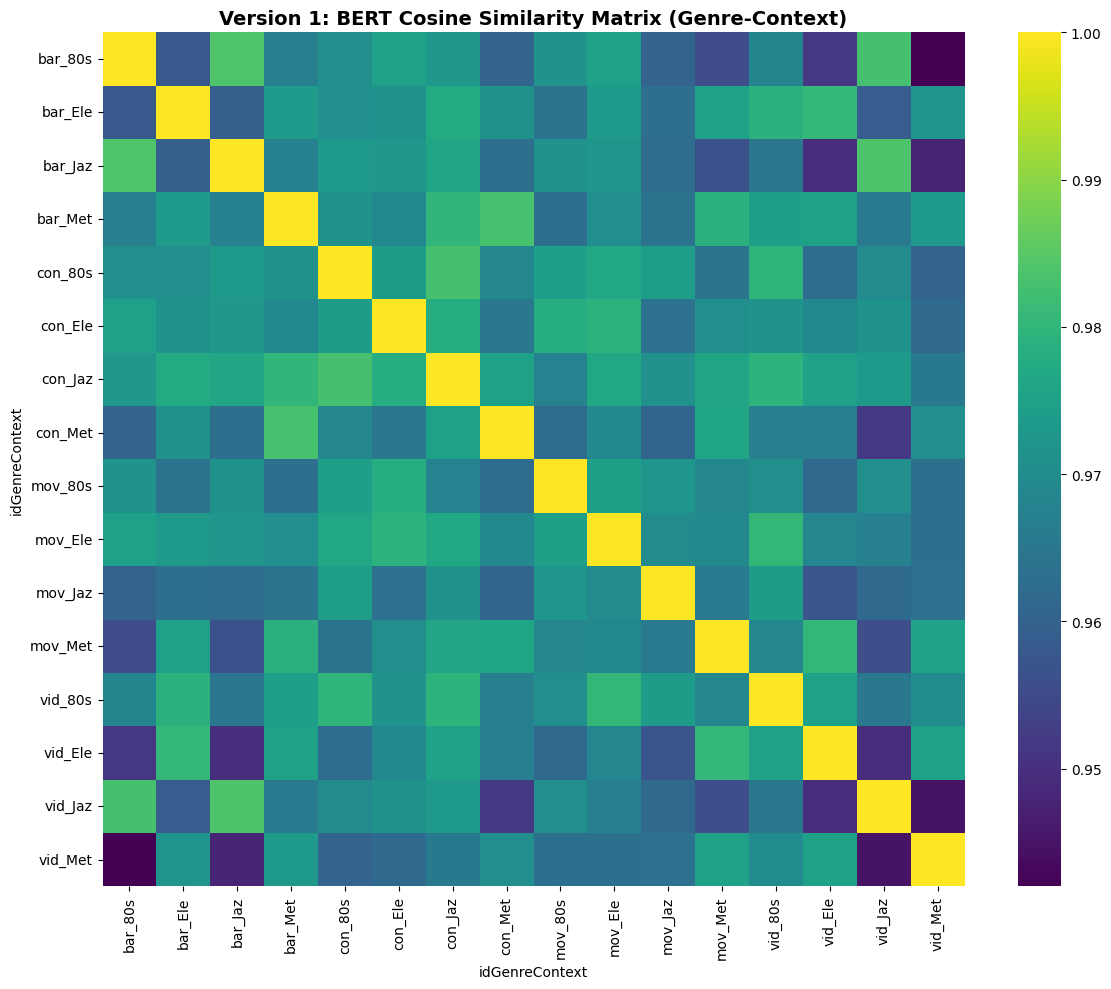

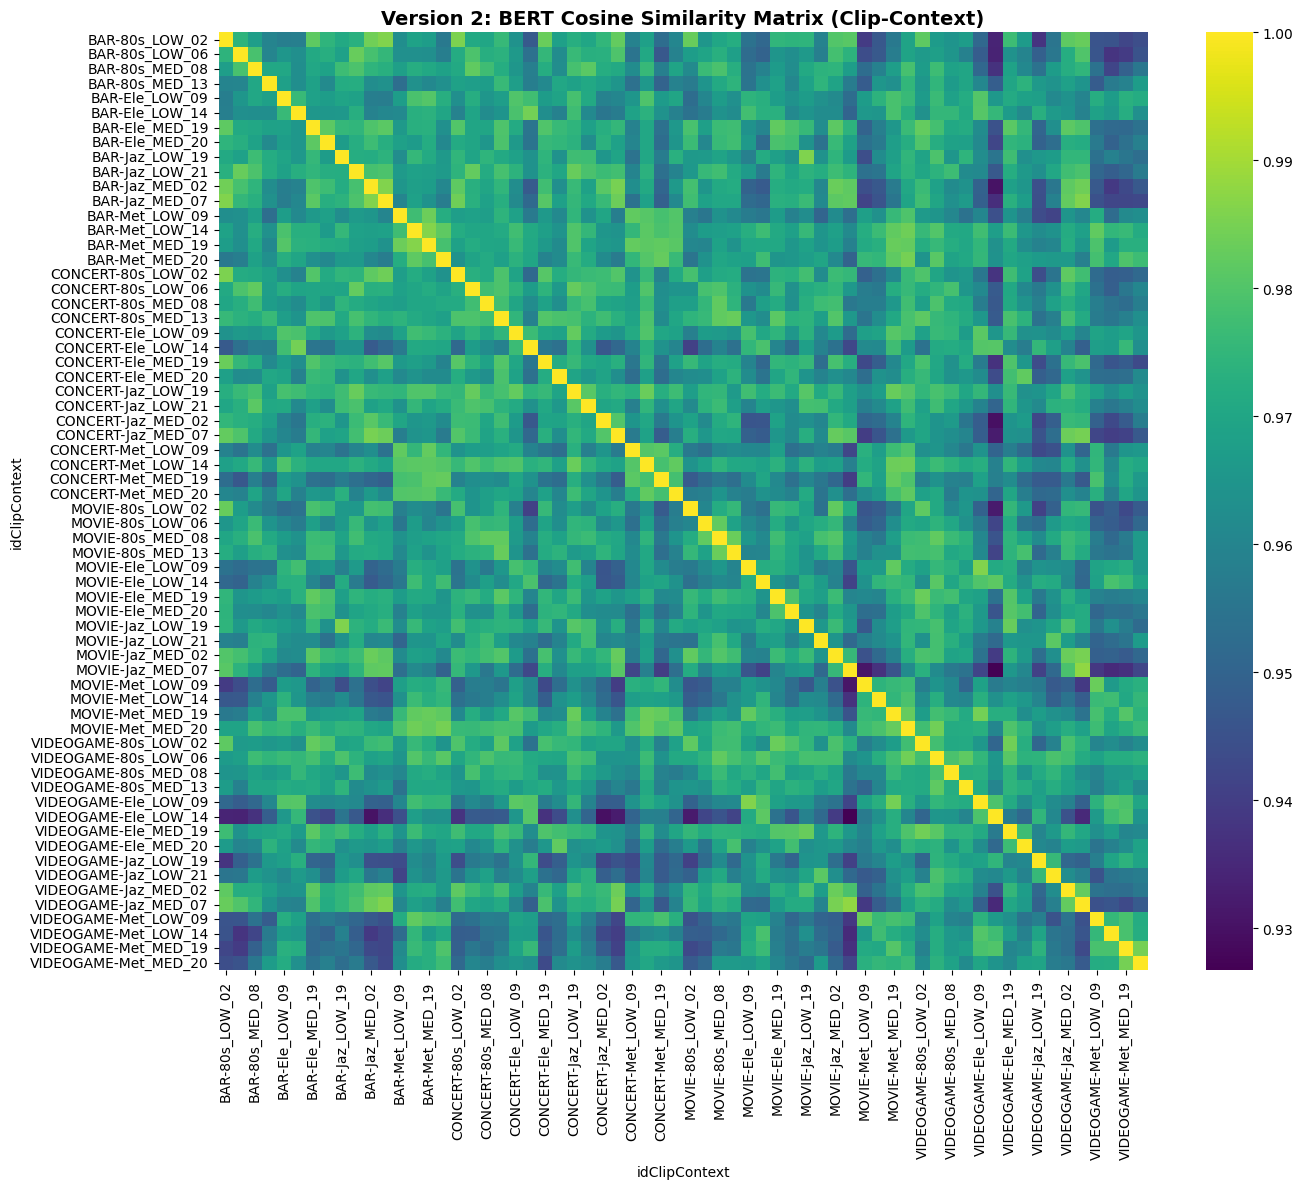

In [9]:
# Visualisation for Version 1
plt.figure(figsize=(12, 10))
sns.heatmap(cosineMatrix_BERT_v1_df, cmap='viridis', annot=False)
plt.title('Version 1: BERT Cosine Similarity Matrix (Genre-Context)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/heatmap_BERT_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualisation for Version 2
plt.figure(figsize=(14, 12))
sns.heatmap(cosineMatrix_BERT_v2_df, cmap='viridis', annot=False)
plt.title('Version 2: BERT Cosine Similarity Matrix (Clip-Context)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/heatmap_BERT_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [10]:
print("\nOutput files created:")
print("  - cosineMatrix_BERT_v1_GenreContext.csv")
print("  - heatmap_BERT_v1_GenreContext.png")
print("  - cosineMatrix_BERT_v2_ClipContext.csv")
print("  - heatmap_BERT_v2_ClipContext.png")


Output files created:
  - cosineMatrix_BERT_v1_GenreContext.csv
  - heatmap_BERT_v1_GenreContext.png
  - cosineMatrix_BERT_v2_ClipContext.csv
  - heatmap_BERT_v2_ClipContext.png


---
## Semantic Similarity Analyses

**OUTPUTS:**

All Representational Dissimilarity Matrix (RDM) masks and similarity measures are saved separately for each version, ready for statistical analysis in R.

=== *ANALYSIS STRUCTURE* ===


**Version 1 (Genre-Context) - 5 conditions:**

* Same context, different genre
* Different context, same genre
* Different context, different genre
* Between (dif.) contexts
* Between (dif.) genres


**Version 2 (Clip-Context) - 7 conditions:**

* Same context, different clip
* Different context, same clip
* Different context, different clip
* Between (dif.) contexts
* Between (dif.) clips
* Within (same) genre
* Between (dif.) genres



====================================
### Version 1: Genre-Context Semantic Similarity
====================================

Set up label columns, NumPy arrays, and stimuli condition masks:

In [11]:
inData_bert_v1 = METdocs_v1
simData_bert_v1 = cosineMatrix_BERT_v1_df

# Extract label columns
labelsCG_bert_v1 = inData_bert_v1['idGenreContext']
labelsGenre_bert_v1 = inData_bert_v1['genre_code']
labelsContext_bert_v1 = inData_bert_v1['context_code']

# Initialise arrays - 8 conditions
sContext_dGenre_bert_v1 = np.zeros(shape=(len(labelsCG_bert_v1), len(labelsCG_bert_v1)))
dContext_sGenre_bert_v1 = np.zeros(shape=(len(labelsCG_bert_v1), len(labelsCG_bert_v1)))
dContext_dGenre_bert_v1 = np.zeros(shape=(len(labelsCG_bert_v1), len(labelsCG_bert_v1)))
bwContext_bert_v1 = np.zeros(shape=(len(labelsCG_bert_v1), len(labelsCG_bert_v1)))
bwGenre_bert_v1 = np.zeros(shape=(len(labelsCG_bert_v1), len(labelsCG_bert_v1)))

# Build condition masks
for irow in range(0, len(labelsCG_bert_v1.values)):
    for icol in range(0, irow):
        same_context = labelsContext_bert_v1.values[irow] == labelsContext_bert_v1.values[icol]
        same_genre = labelsGenre_bert_v1.values[irow] == labelsGenre_bert_v1.values[icol]

        # Stimuli combinatorial conditions
        if same_context and not same_genre:
            sContext_dGenre_bert_v1[irow, icol] = 1
        elif not same_context and same_genre:
            dContext_sGenre_bert_v1[irow, icol] = 1
        elif not same_context and not same_genre:
            dContext_dGenre_bert_v1[irow, icol] = 1

        # Between context
        if not same_context:
            bwContext_bert_v1[irow, icol] = 1

        # Between genre
        if not same_genre:
            bwGenre_bert_v1[irow, icol] = 1

Extract similarity values for each condition:

In [12]:
simMeasures_bert_v1 = {'type': [], 'sim': []}

conditions_bert_v1 = {
    'sContext_dGenre': sContext_dGenre_bert_v1,
    'dContext_sGenre': dContext_sGenre_bert_v1,
    'dContext_dGenre': dContext_dGenre_bert_v1,
    'bwContext': bwContext_bert_v1,
    'bwGenre': bwGenre_bert_v1
}

for condition_name, condition_mask in conditions_bert_v1.items():
    simVals = simData_bert_v1.values[condition_mask == 1]
    for val in simVals:
        simMeasures_bert_v1['type'].append(condition_name)
        simMeasures_bert_v1['sim'].append(val)

# Create DataFrame
simMeasuresDF_bert_v1 = pd.DataFrame(data=simMeasures_bert_v1)
simMeasuresDF_bert_v1 = simMeasuresDF_bert_v1.replace([np.inf, -np.inf], np.nan)

print(f"\nVersion 1 BERT Similarity Measures extracted (8 conditions):")
print(simMeasuresDF_bert_v1.groupby('type').agg({'sim': ['count', 'mean', 'std']}))

# Save outputs
simMeasuresDF_bert_v1.to_csv('/content/context-framed-listening/NLP_outputs/BERT/simMeasuresDF_BERT_v1_GenreContext.csv', encoding='utf-8', index=False)
pd.DataFrame(sContext_dGenre_bert_v1).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_sContext_dGenre_BERT_v1.csv', encoding='utf-8')
pd.DataFrame(dContext_sGenre_bert_v1).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_dContext_sGenre_BERT_v1.csv', encoding='utf-8')
pd.DataFrame(dContext_dGenre_bert_v1).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_dContext_dGenre_BERT_v1.csv', encoding='utf-8')
pd.DataFrame(bwContext_bert_v1).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_bwContext_BERT_v1.csv', encoding='utf-8')
pd.DataFrame(bwGenre_bert_v1).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_bwGenre_BERT_v1.csv', encoding='utf-8')



Version 1 BERT Similarity Measures extracted (8 conditions):
                  sim                    
                count      mean       std
type                                     
bwContext          96  0.968965  0.008278
bwGenre            96  0.967801  0.008626
dContext_dGenre    72  0.967452  0.008478
dContext_sGenre    24  0.973503  0.005700
sContext_dGenre    24  0.968848  0.009159


====================================
### Version 2: Clip-Context Semantic Similarity
====================================

Set up label columns, NumPy arrays, and stimuli condition masks:

In [13]:
inData_bert_v2 = METdocs_v2
simData_bert_v2 = cosineMatrix_BERT_v2_df

# Extract label columns
labelsCG_bert_v2 = inData_bert_v2['idClipContext']
labelsClip_bert_v2 = inData_bert_v2['clip_name']
labelsGenre_bert_v2 = inData_bert_v2['genre_code']
labelsContext_bert_v2 = inData_bert_v2['context_word']

# Initialise arrays
sContext_dClip_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
dContext_sClip_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
dContext_dClip_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
bwContext_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
bwClip_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
bwGenre_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))
wiGenre_bert_v2 = np.zeros(shape=(len(labelsCG_bert_v2), len(labelsCG_bert_v2)))

# Build condition masks
for irow in range(0, len(labelsCG_bert_v2.values)):
    for icol in range(0, irow):
        same_context = labelsContext_bert_v2.values[irow] == labelsContext_bert_v2.values[icol]
        same_clip = labelsClip_bert_v2.values[irow] == labelsClip_bert_v2.values[icol]
        same_genre = labelsGenre_bert_v2.values[irow] == labelsGenre_bert_v2.values[icol]

        # Stimuli combinatorial conditions
        if same_context and not same_clip:
            sContext_dClip_bert_v2[irow, icol] = 1
        elif not same_context and same_clip:
            dContext_sClip_bert_v2[irow, icol] = 1
        elif not same_context and not same_clip:
            dContext_dClip_bert_v2[irow, icol] = 1

        # Between context
        if same_context:
            bwContext_bert_v2[irow, icol] = 1

        # Between clip
        if same_clip:
            bwClip_bert_v2[irow, icol] = 1

        # Within/Between genre
        if same_genre:
            wiGenre_bert_v2[irow, icol] = 1
        else:
            bwGenre_bert_v2[irow, icol] = 1

Extract similarity values for each condition:

In [14]:
simMeasures_bert_v2 = {'type': [], 'sim': []}

conditions_bert_v2 = {
    'sContext_dClip': sContext_dClip_bert_v2,
    'dContext_sClip': dContext_sClip_bert_v2,
    'dContext_dClip': dContext_dClip_bert_v2,
    'bwContext': bwContext_bert_v2,
    'bwClip': bwClip_bert_v2,
    'bwGenre': bwGenre_bert_v2,
    'wiGenre': wiGenre_bert_v2
}

for condition_name, condition_mask in conditions_bert_v2.items():
    simVals = simData_bert_v2.values[condition_mask == 1]
    for val in simVals:
        simMeasures_bert_v2['type'].append(condition_name)
        simMeasures_bert_v2['sim'].append(val)

# Create DataFrame
simMeasuresDF_bert_v2 = pd.DataFrame(data=simMeasures_bert_v2)
simMeasuresDF_bert_v2 = simMeasuresDF_bert_v2.replace([np.inf, -np.inf], np.nan)

print(f"\nVersion 2 BERT Similarity Measures extracted (10 conditions):")
print(simMeasuresDF_bert_v2.groupby('type').agg({'sim': ['count', 'mean', 'std']}))

# Save outputs
simMeasuresDF_bert_v2.to_csv('/content/context-framed-listening/NLP_outputs/BERT/simMeasuresDF_BERT_v2_ClipContext.csv', encoding='utf-8', index=False)
pd.DataFrame(sContext_dClip_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_sContext_dClip_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(dContext_sClip_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_dContext_sClip_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(dContext_dClip_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_dContext_dClip_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(bwContext_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_bwContext_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(bwClip_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_bwClip_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(bwGenre_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_bwGenre_BERT_v2.csv', encoding='utf-8')
pd.DataFrame(wiGenre_bert_v2).to_csv('/content/context-framed-listening/NLP_outputs/BERT/RDM_wiGenre_BERT_v2.csv', encoding='utf-8')



Version 2 BERT Similarity Measures extracted (10 conditions):
                 sim                    
               count      mean       std
type                                    
bwClip            96  0.977453  0.005558
bwContext        480  0.967811  0.009247
bwGenre         1536  0.964419  0.010031
dContext_dClip  1440  0.964908  0.010306
dContext_sClip    96  0.977453  0.005558
sContext_dClip   480  0.967811  0.009247
wiGenre          480  0.971884  0.008873


====================================
#### VISUALISATIONS for BERT analyses
====================================

* Box plots
* Violin plots
* Bar plots

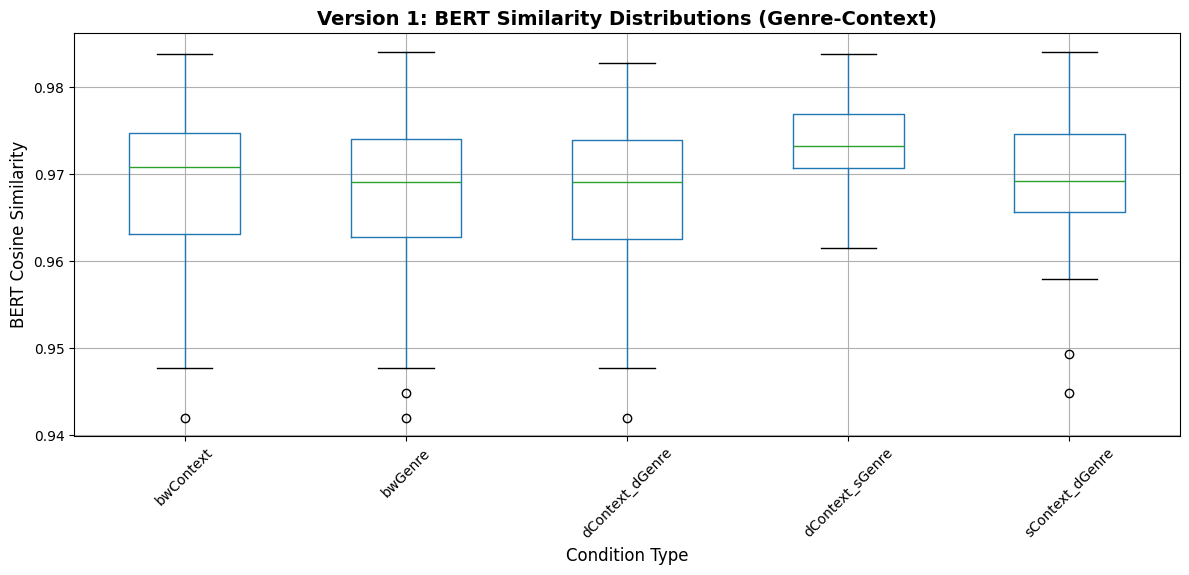

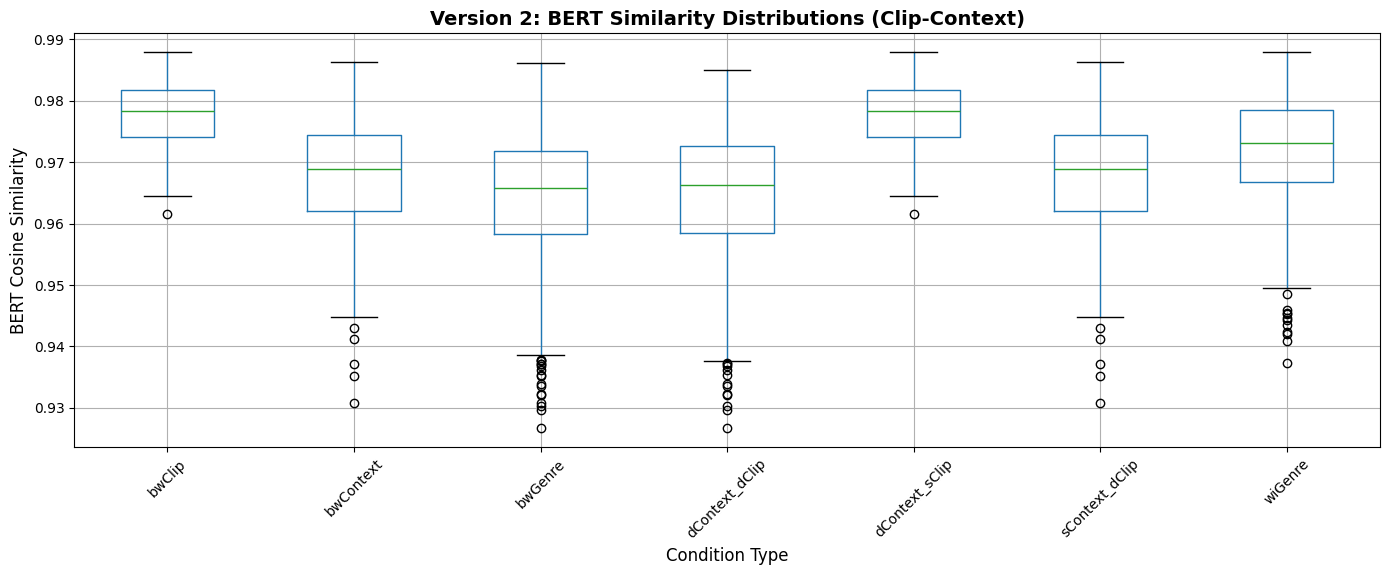

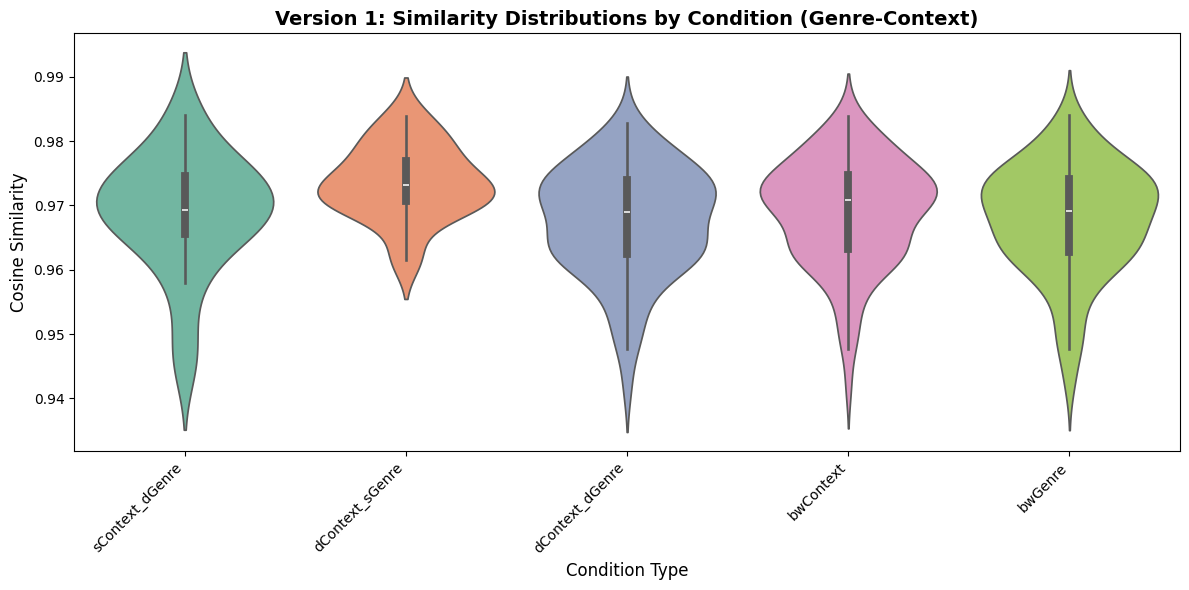

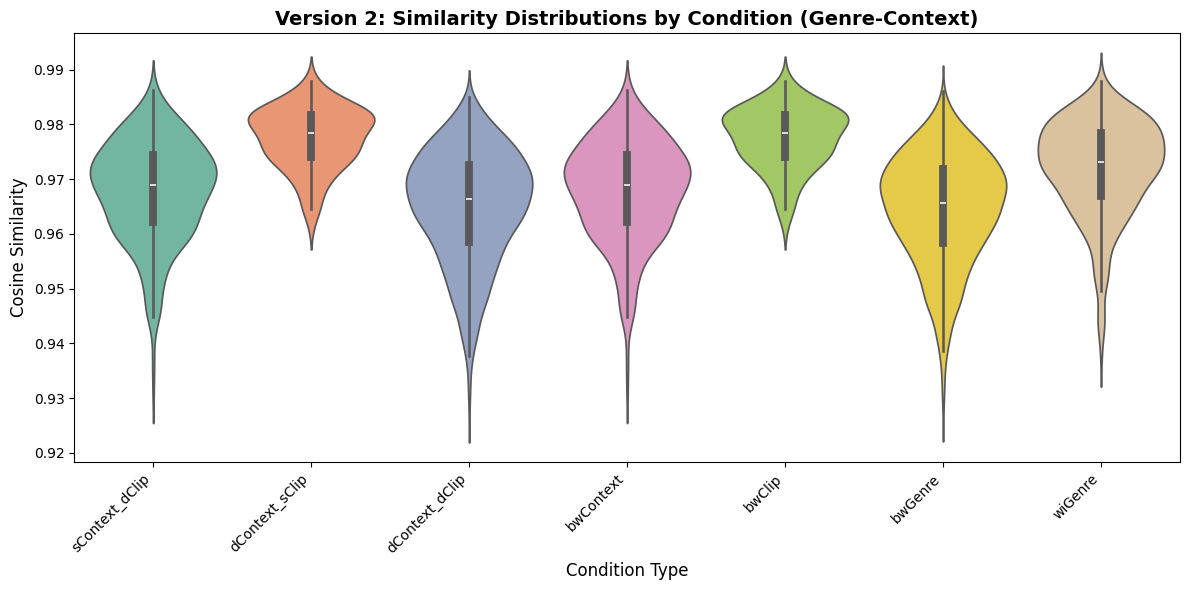

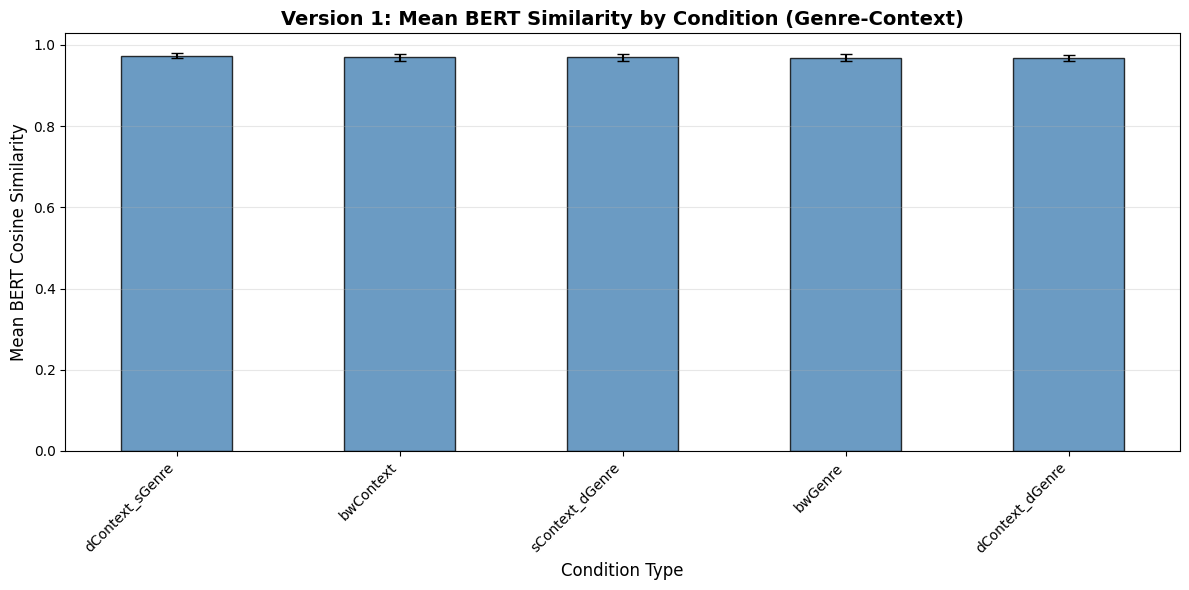

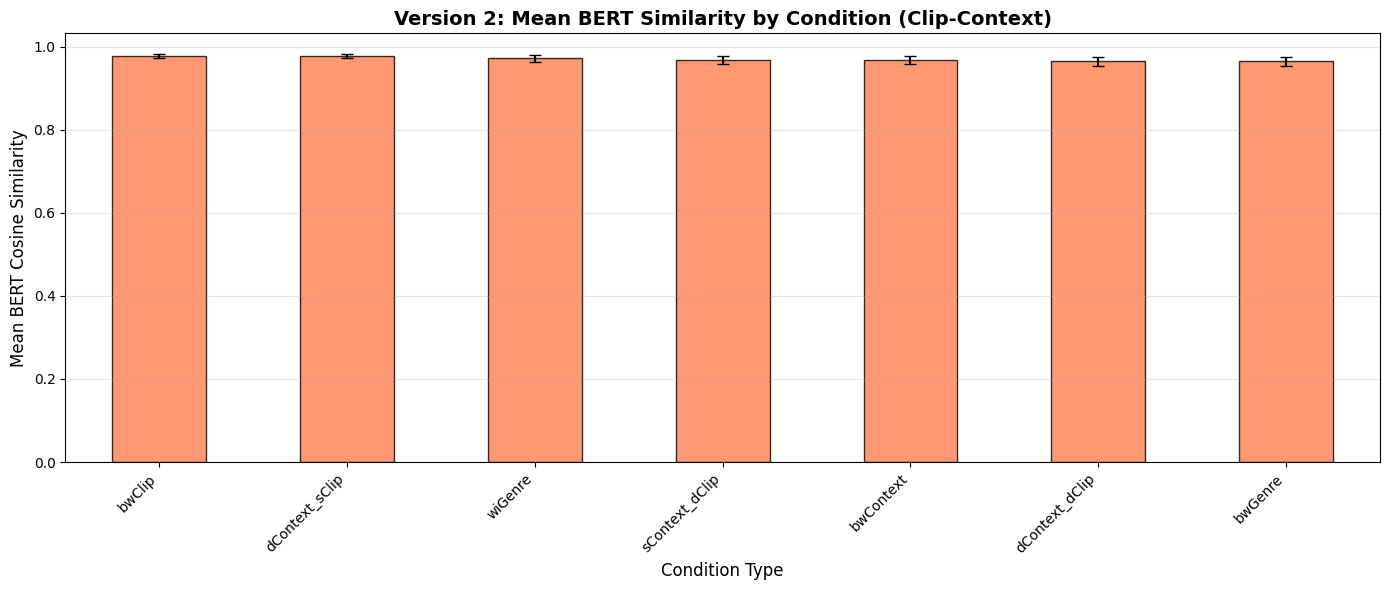

In [16]:
# Box plots comparing conditions - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
simMeasuresDF_bert_v1.boxplot(column='sim', by='type', ax=ax, rot=45)
ax.set_title('Version 1: BERT Similarity Distributions (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('BERT Cosine Similarity', fontsize=12)
plt.suptitle('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_boxplot_BERT_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Box plots comparing conditions - Version 2
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
simMeasuresDF_bert_v2.boxplot(column='sim', by='type', ax=ax, rot=45)
ax.set_title('Version 2: BERT Similarity Distributions (Clip-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('BERT Cosine Similarity', fontsize=12)
plt.suptitle('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_boxplot_BERT_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plot comparing conditions - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(data=simMeasuresDF_bert_v1, x='type', y='sim', hue='type', ax=ax, palette='Set2', legend=False)
ax.set_title('Version 1: Similarity Distributions by Condition (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_violin_BERT_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plot comparing conditions - Version 2
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot(data=simMeasuresDF_bert_v2, x='type', y='sim', hue='type', ax=ax, palette='Set2', legend=False)
ax.set_title('Version 2: Similarity Distributions by Condition (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_violin_BERT_v2_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar plots with means - Version 1
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
means_bert_v1 = simMeasuresDF_bert_v1.groupby('type')['sim'].mean().sort_values(ascending=False)
stds_bert_v1 = simMeasuresDF_bert_v1.groupby('type')['sim'].std()
means_bert_v1.plot(kind='bar', ax=ax, yerr=stds_bert_v1, capsize=4, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_title('Version 1: Mean BERT Similarity by Condition (Genre-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Mean BERT Cosine Similarity', fontsize=12)
ax.set_xticklabels(means_bert_v1.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_means_BERT_v1_GenreContext.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar plots with means - Version 2
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
means_bert_v2 = simMeasuresDF_bert_v2.groupby('type')['sim'].mean().sort_values(ascending=False)
stds_bert_v2 = simMeasuresDF_bert_v2.groupby('type')['sim'].std()
means_bert_v2.plot(kind='bar', ax=ax, yerr=stds_bert_v2, capsize=4, color='coral', edgecolor='black', alpha=0.8)
ax.set_title('Version 2: Mean BERT Similarity by Condition (Clip-Context)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition Type', fontsize=12)
ax.set_ylabel('Mean BERT Cosine Similarity', fontsize=12)
ax.set_xticklabels(means_bert_v2.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/similarity_means_BERT_v2_ClipContext.png', dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [17]:
print("\nVersion 1 (Genre-Context) BERT Output Files:")
print("  Data Files:")
print("    - cosineMatrix_BERT_v1_GenreContext.csv")
print("    - simMeasuresDF_BERT_v1_GenreContext.csv")
print("    - RDM masks (8 CSV files)")
print("  Visualizations:")
print("    - heatmap_BERT_v1_GenreContext.png")
print("    - similarity_boxplot_BERT_v1_GenreContext.png")
print("    - similarity_violin_BERT_v1_GenreContext.png")
print("    - similarity_means_BERT_v1_GenreContext.png")
print("\nVersion 2 (Clip-Context) BERT Output Files:")
print("  Data Files:")
print("    - cosineMatrix_BERT_v2_ClipContext.csv")
print("    - simMeasuresDF_BERT_v2_ClipContext.csv")
print("    - RDM masks (10 CSV files)")
print("  Visualizations:")
print("    - heatmap_BERT_v2_ClipContext.png")
print("    - similarity_boxplot_BERT_v2_ClipContext.png")
print("    - similarity_violin_BERT_v2_GenreContext.png")
print("    - similarity_means_BERT_v2_ClipContext.png")


Version 1 (Genre-Context) BERT Output Files:
  Data Files:
    - cosineMatrix_BERT_v1_GenreContext.csv
    - simMeasuresDF_BERT_v1_GenreContext.csv
    - RDM masks (8 CSV files)
  Visualizations:
    - heatmap_BERT_v1_GenreContext.png
    - similarity_boxplot_BERT_v1_GenreContext.png
    - similarity_violin_BERT_v1_GenreContext.png
    - similarity_means_BERT_v1_GenreContext.png

Version 2 (Clip-Context) BERT Output Files:
  Data Files:
    - cosineMatrix_BERT_v2_ClipContext.csv
    - simMeasuresDF_BERT_v2_ClipContext.csv
    - RDM masks (10 CSV files)
  Visualizations:
    - heatmap_BERT_v2_ClipContext.png
    - similarity_boxplot_BERT_v2_ClipContext.png
    - similarity_violin_BERT_v2_GenreContext.png
    - similarity_means_BERT_v2_ClipContext.png
